In [11]:
import pandas as pd, numpy as np
import sys, os
import matplotlib.pyplot as plt, seaborn as sns
sys.path.append(os.path.abspath('..'))
from src.loaders import load_train_merged
pd.set_option("display.max_columns", 120)

train = load_train_merged()
train.shape, train["isFraud"].value_counts(normalize=True)

Loading from: C:\Users\domen\Projects\ieee-fraud\data\raw\train_transaction.csv


((590540, 434),
 isFraud
 0    0.96501
 1    0.03499
 Name: proportion, dtype: float64)

In [12]:
# Some Helper functions

#formats 0.1234 into 12.34%
def percent(x): 
    return f"{round(100 * x, 2)}%"

# For each value in `key`, count rows (n) and average y (rate).
# Keep only groups with min_count rows.
def rate_by(df, key, y="isFraud", min_count=50):
    tmp = df.groupby(key)[y].agg(["count", "mean"]).reset_index()
    tmp = tmp.rename(columns={"count": "n", "mean": "rate"})
    tmp = tmp[tmp["n"] >= min_count]
    tmp = tmp.sort_values("rate", ascending=False)
    return tmp


# returns top k most common values in col
def top_k_counts(df, col, k=15):
    val_count = df[col].value_counts(dropna=False).head(k)
    out = val_count.reset_index()
    out.columns = [col, 'count']
    return out
    
#True only if every column in 'cols' exists in df. 
def safe_has(df,*cols):
    for c in cols:
        if c not in df.columns:
            return False
    return True


In [13]:
#Exploring size
rows, cols = train.shape
print("Rows:", rows, "Cols:", cols)

#Label counting and percentages
label_counts = train["isFraud"].value_counts()
label_share = (label_counts / label_counts.sum())
print("Label counts:\n", label_counts)
print("Label share:\n", label_share.apply(percent))

# data types 
print("\nDtype counts:\n", train.dtypes.value_counts())

# memory
mem_mb = train.memory_usage(deep=True).sum() / (1024**2)
print(f"\n Memory: {mem_mb:.2f} MB")

Rows: 590540 Cols: 434
Label counts:
 isFraud
0    569877
1     20663
Name: count, dtype: int64
Label share:
 isFraud
0    96.5%
1     3.5%
Name: count, dtype: object

Dtype counts:
 float64    399
object      31
int64        4
Name: count, dtype: int64

 Memory: 2513.97 MB


In [14]:
# na per column , top 30
na_rate = train.isna().mean().sort_values(ascending=False)

print("Top missing columns:\n", (percent(na_rate.head(30))))

# duplicates
dups = train.duplicated().sum()
print("\nDuplicate rows:", dups)

Top missing columns:
 id_24    99.20
id_25    99.13
id_07    99.13
id_08    99.13
id_21    99.13
id_26    99.13
id_27    99.12
id_23    99.12
id_22    99.12
dist2    93.63
D7       93.41
id_18    92.36
D13      89.51
D14      89.47
D12      89.04
id_04    88.77
id_03    88.77
D6       87.61
id_33    87.59
id_09    87.31
D8       87.31
id_10    87.31
D9       87.31
id_30    86.87
id_32    86.86
id_34    86.82
id_14    86.45
V138     86.12
V139     86.12
V148     86.12
dtype: float64%

Duplicate rows: 0


In [15]:
#Cardinality (unique values per column)
cat_cols = [c for c in train.columns if train[c].dtype == "object"]
cardinality = {c: train[c].nunique(dropna=False) for c in cat_cols}
cardinality = pd.Series(cardinality).sort_values(ascending=False)
print("Top cardinality categories:\n", cardinality.head(15))

Top cardinality categories:
 DeviceInfo       1787
id_33             261
id_31             131
id_30              76
R_emaildomain      61
P_emaildomain      60
ProductCD           5
card6               5
card4               5
id_34               5
id_15               4
M4                  4
id_23               4
M2                  3
M1                  3
dtype: int64


In [16]:
# Some descriptive stats, count, mean, std, min, max, and percentiles

num_cols = train.select_dtypes(include=[np.number]).columns.tolist()
if "isFraud" in num_cols:
    num_cols.remove("isFraud")

# summary table
summary = train[num_cols].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).T
display(summary.head(12))

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
TransactionID,590540.0,3.282270e+06,1.704744e+05,2987000.000,2992905.390,3016526.95,3134634.750,3282269.500,3429904.25,3548012.05,3571633.61,3.577539e+06
TransactionDT,590540.0,7.372311e+06,4.617224e+06,86400.000,185058.820,751946.50,3027057.750,7306527.500,11246620.00,14857872.15,15629766.04,1.581113e+07
TransactionAmt,590540.0,1.350272e+02,2.391625e+02,0.251,9.244,20.00,43.321,68.769,125.00,445.00,1104.00,3.193739e+04
card1,590540.0,9.898735e+03,4.901170e+03,1000.000,1338.000,2039.00,6019.000,9678.000,14184.00,17319.00,18238.00,1.839600e+04
card2,581607.0,3.625555e+02,1.577932e+02,100.000,100.000,111.00,214.000,361.000,512.00,567.00,583.00,6.000000e+02
card3,588975.0,1.531949e+02,1.133644e+01,100.000,144.000,150.00,150.000,150.000,150.00,185.00,185.00,2.310000e+02
card5,586281.0,1.992789e+02,4.124445e+01,100.000,102.000,102.00,166.000,226.000,226.00,226.00,226.00,2.370000e+02
addr1,524834.0,2.907338e+02,1.017411e+02,100.000,123.000,126.00,204.000,299.000,330.00,485.00,512.00,5.400000e+02
addr2,524834.0,8.680063e+01,2.690623e+00,10.000,87.000,87.00,87.000,87.000,87.00,87.00,87.00,1.020000e+02
dist1,238269.0,1.185022e+02,3.718720e+02,0.000,0.000,0.00,3.000,8.000,24.00,846.00,2040.00,1.028600e+04


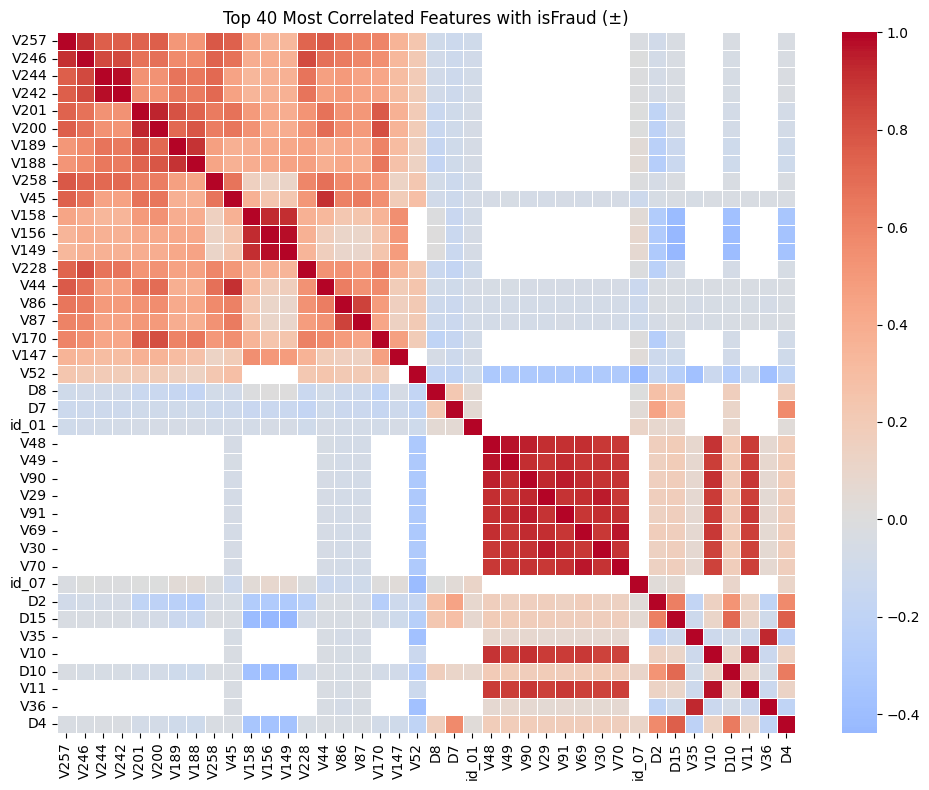

In [17]:

# compute correlations (numeric columns only)
corr = train.corr(numeric_only=True)['isFraud'].drop('isFraud')

# pick top 20 positive and top 20 negative correlations
top_pos = corr.sort_values(ascending=False).head(20)
top_neg = corr.sort_values(ascending=True).head(20)

# combine and keep unique names
top_features = pd.concat([top_pos, top_neg]).index.unique()

# create heatmap
plt.figure(figsize=(10,8))
sns.heatmap(train[top_features].corr(), 
            cmap='coolwarm', 
            center=0, 
            annot=False, 
            linewidths=0.5)
plt.title("Top 40 Most Correlated Features with isFraud (±)")
plt.tight_layout()
plt.show()

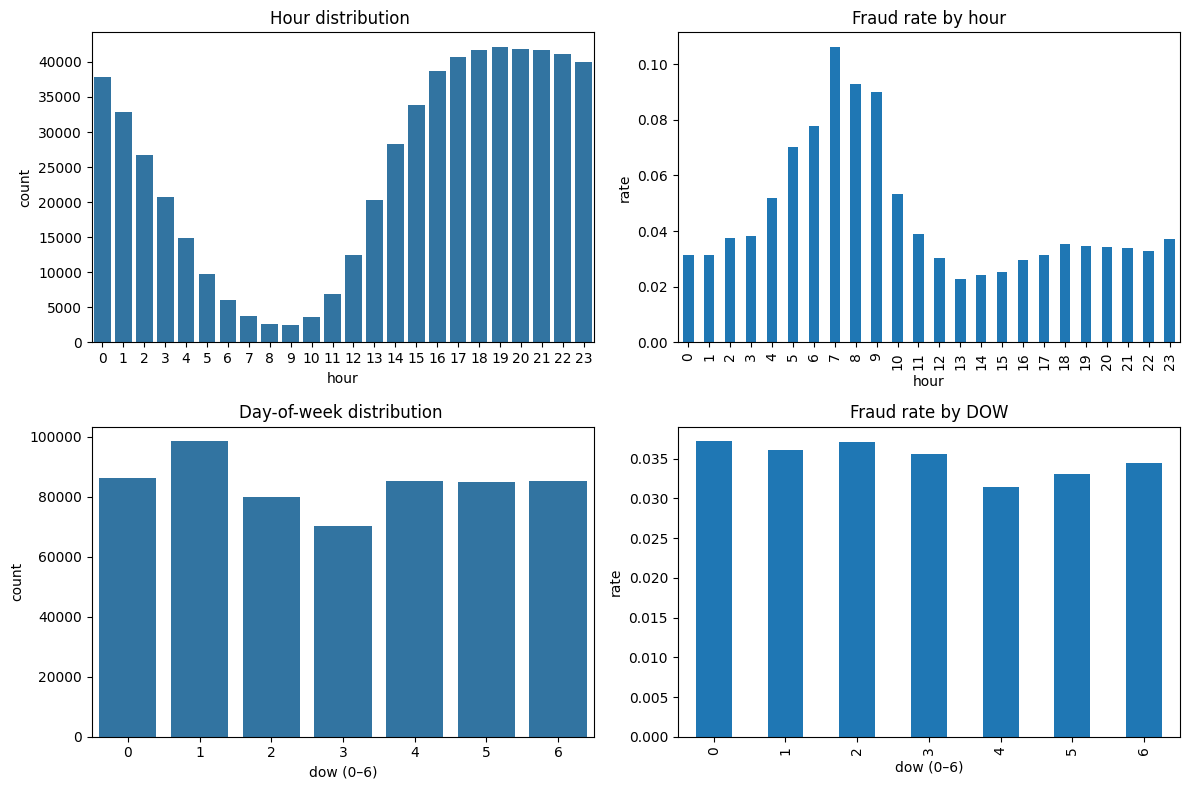

In [18]:
train["day"]  = (train["TransactionDT"] // (24*60*60)).astype("int32")
train["hour"] = ((train["TransactionDT"] // 3600) % 24).astype("int16")
train["dow"]  = (train["day"] % 7).astype("int8")   # 0..6, arbitrary reference start

# plotting: 2x2 grid
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Volume by hour (sample for speed)
sns.countplot(x="hour", data=train, ax=ax[0,0])
ax[0,0].set_title("Hour distribution ")

# Fraud rate by hour
train.groupby("hour")["isFraud"].mean().plot(kind="bar", ax=ax[0,1])
ax[0,1].set_title("Fraud rate by hour"); ax[0,1].set_xlabel("hour"); ax[0,1].set_ylabel("rate")

# Volume by Day of week
sns.countplot(x="dow", data=train, ax=ax[1,0])
ax[1,0].set_title("Day-of-week distribution "); ax[1,0].set_xlabel("dow (0–6)")

# Fraud rate by day of week
train.groupby("dow")["isFraud"].mean().plot(kind="bar", ax=ax[1,1])
ax[1,1].set_title("Fraud rate by DOW"); ax[1,1].set_xlabel("dow (0–6)"); ax[1,1].set_ylabel("rate")

plt.tight_layout(); plt.show()

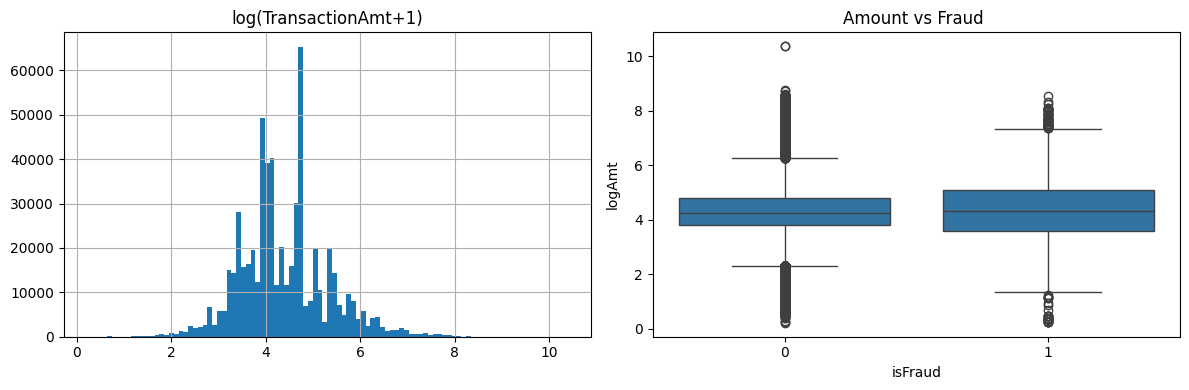

In [19]:
train["logAmt"] = np.log1p(train["TransactionAmt"])
fig, ax = plt.subplots(1,2, figsize=(12,4))
train["logAmt"].hist(bins=100, ax=ax[0]); ax[0].set_title("log(TransactionAmt+1)")
sns.boxplot(x="isFraud", y="logAmt", data=train, ax=ax[1])
ax[1].set_title("Amount vs Fraud ")
plt.tight_layout(); plt.show()


Fraud rate by ProductCD:
 ProductCD
C    0.116873
S    0.058996
H    0.047662
R    0.037826
W    0.020399
Name: isFraud, dtype: float64


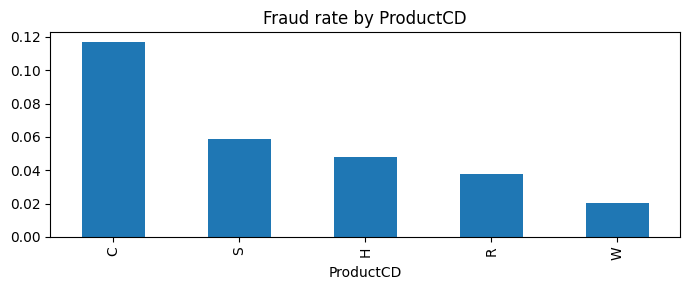


Fraud rate by card4:
 card4
discover            0.077282
visa                0.034756
mastercard          0.034331
american express    0.028698
Name: isFraud, dtype: float64


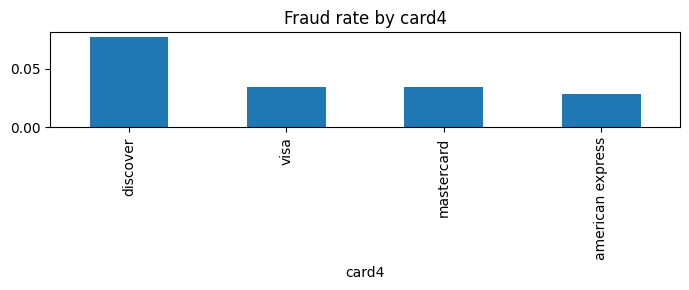


Fraud rate by card6:
 card6
credit             0.066785
debit              0.024263
charge card        0.000000
debit or credit    0.000000
Name: isFraud, dtype: float64


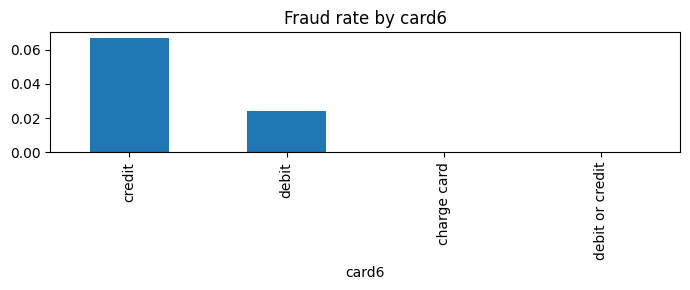


Fraud rate by DeviceType:
 DeviceType
mobile     0.101662
desktop    0.065215
Name: isFraud, dtype: float64


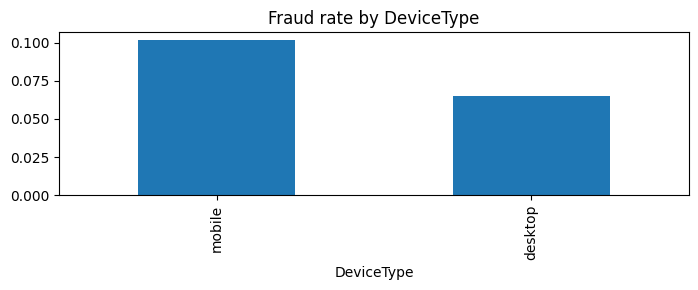


Fraud rate by P_emaildomain:
 P_emaildomain
protonmail.com      0.407895
mail.com            0.189624
outlook.es          0.130137
aim.com             0.126984
outlook.com         0.094584
hotmail.es          0.065574
live.com.mx         0.054740
hotmail.com         0.052950
gmail.com           0.043542
yahoo.fr            0.034965
embarqmail.com      0.034615
mac.com             0.032110
icloud.com          0.031434
comcast.net         0.031187
charter.net         0.030637
frontier.com        0.028571
bellsouth.net       0.027763
live.com            0.027622
frontiernet.net     0.025641
anonymous.com       0.023217
suddenlink.net      0.022857
yahoo.com           0.022757
gmail               0.022177
msn.com             0.021994
aol.com             0.021811
earthlink.net       0.021401
ymail.com           0.020868
cox.net             0.020818
cableone.net        0.018868
juno.com            0.018634
me.com              0.017740
optonline.net       0.016815
yahoo.es            0.01492

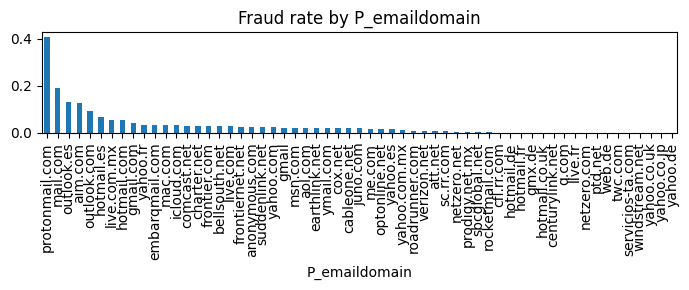

In [20]:
#Some slices of categorical risk.
for col in ["ProductCD", "card4", "card6", "DeviceType", "P_emaildomain"]:
    if safe_has(train, col):
        t = train.groupby(col)["isFraud"].mean().sort_values(ascending=False)
        print(f"\nFraud rate by {col}:\n", t)
        t.plot(kind="bar", figsize=(7,3), title=f"Fraud rate by {col}")
        plt.tight_layout(); plt.show()